Epoch 10: Average loss = 1.8516
Epoch 20: Average loss = 1.8173
Epoch 30: Average loss = 1.7009
Epoch 40: Average loss = 1.6862
Epoch 50: Average loss = 1.6670
Epoch 60: Average loss = 1.6959
Epoch 70: Average loss = 1.6813
Epoch 80: Average loss = 1.6821
Epoch 90: Average loss = 1.6877
Epoch 100: Average loss = 1.6800
Epoch 110: Average loss = 1.6775
Epoch 120: Average loss = 1.6932
Epoch 130: Average loss = 1.6744
Epoch 140: Average loss = 1.6743
Epoch 150: Average loss = 1.6715
Epoch 160: Average loss = 1.6740
Epoch 170: Average loss = 1.6673
Epoch 180: Average loss = 1.6663
Epoch 190: Average loss = 1.6932
Epoch 200: Average loss = 1.6731
Epoch 210: Average loss = 1.6716
Epoch 220: Average loss = 1.6749
Epoch 230: Average loss = 1.6947
Epoch 240: Average loss = 1.6777
Epoch 250: Average loss = 1.6733
Epoch 260: Average loss = 1.6683
Epoch 270: Average loss = 1.6811
Epoch 280: Average loss = 1.6831
Epoch 290: Average loss = 1.6817
Epoch 300: Average loss = 1.6830
Epoch 310: Average 

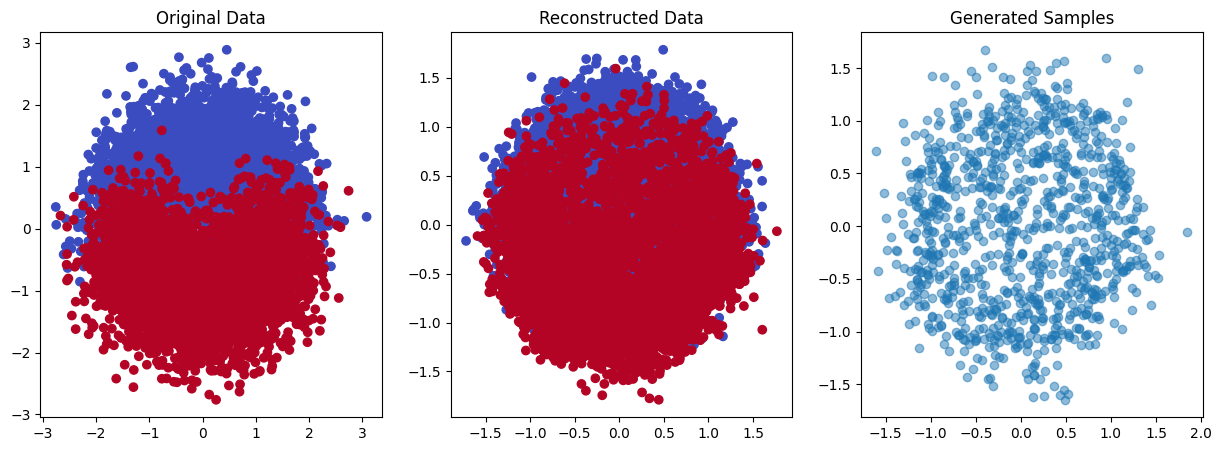

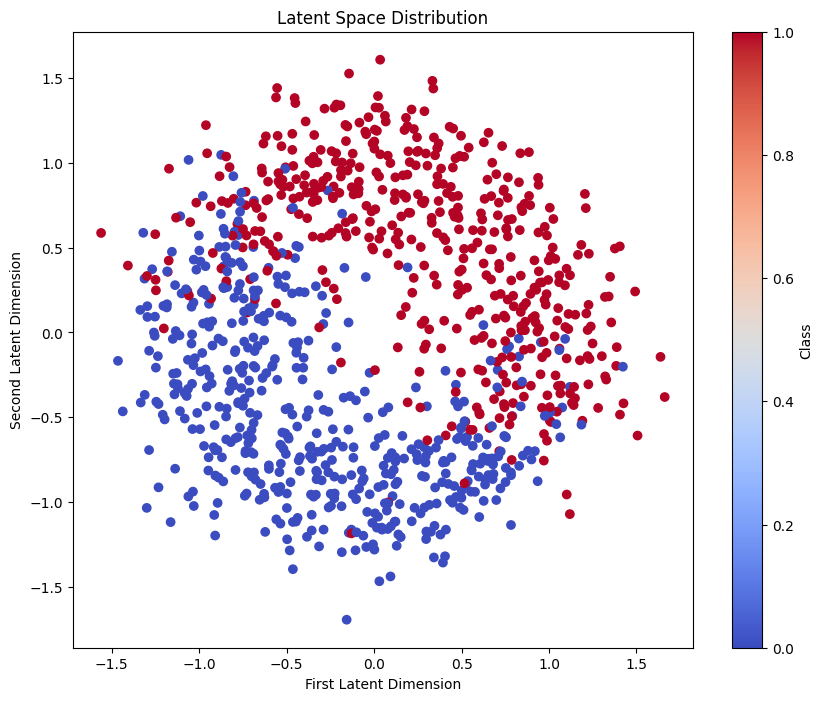

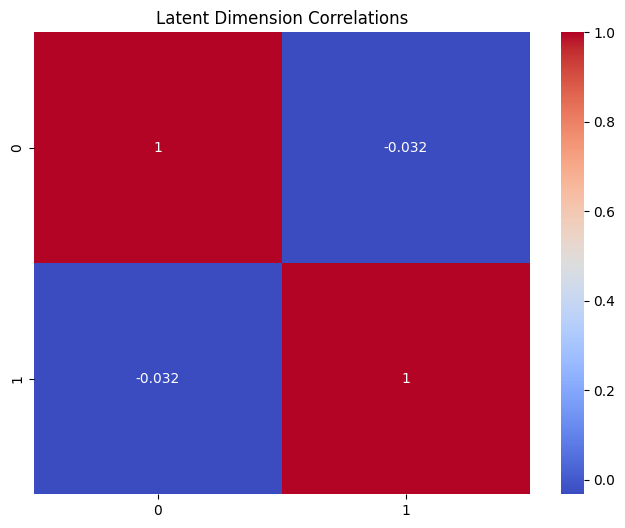

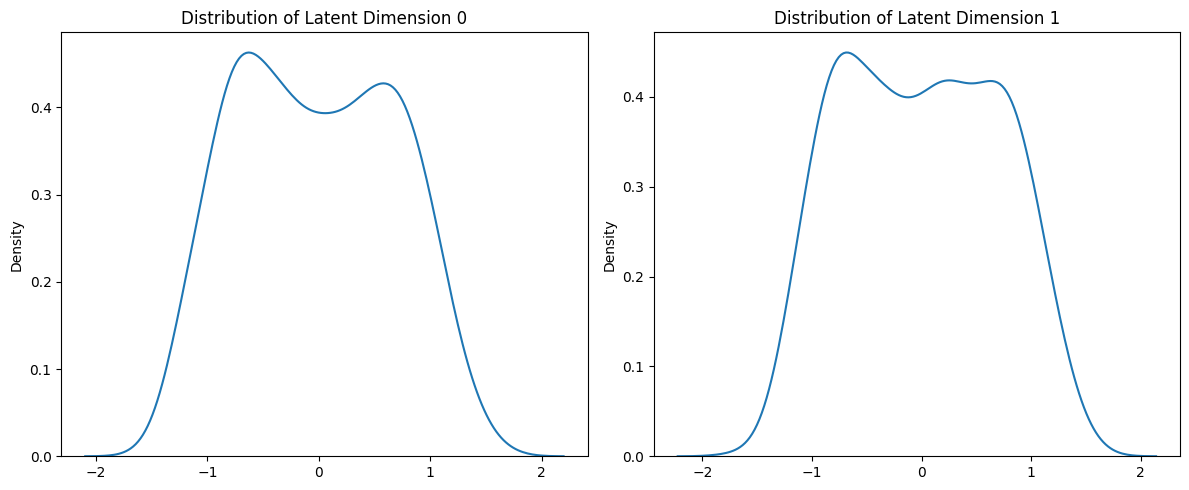


Disentanglement Metrics:
mig: 0.000
sparsity: 0.077
avg_correlation: 0.012


c:\Users\a4446\AppData\Local\miniconda3\envs\llm\Lib\site-packages\sklearn\metrics\cluster\_supervised.py:59: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
c:\Users\a4446\AppData\Local\miniconda3\envs\llm\Lib\site-packages\sklearn\metrics\cluster\_supervised.py:59: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
c:\Users\a4446\AppData\Local\miniconda3\envs\llm\Lib\site-packages\sklearn\metrics\cluster\_supervised.py:59: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
c:\Users\a4446\AppData\Local\miniconda3\envs\llm\Lib\site-packages\sklearn\metrics\cluster\_supervised.py:59: UserWarning: Clustering metrics expects discrete values but recei

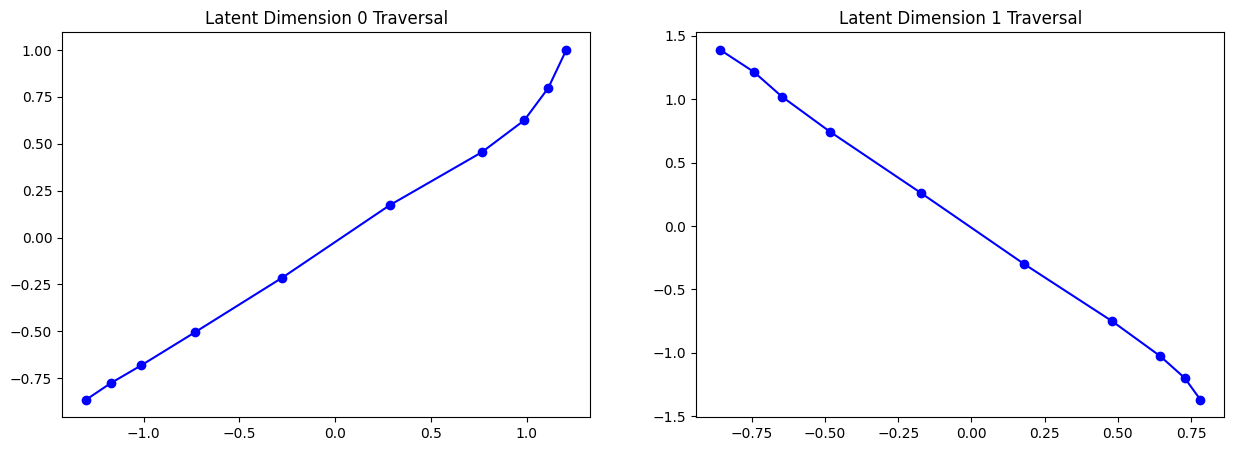

In [5]:
import torch
import torch.utils.data
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import mutual_info_score
import seaborn as sns

class VAEAnalyzer:
    def __init__(self, vae_model, img_size=(1, 2)):
        self.model = vae_model
        self.img_size = img_size
        self.model.eval()

    def compute_advanced_disentanglement_metrics(self, data_loader):
        """
        Compute multiple disentanglement metrics
        """
        # Collect encodings
        encodings = []
        with torch.no_grad():
            for batch, _ in data_loader:
                mu, _ = self.model.encode(batch)
                encodings.append(mu)
        encodings = torch.cat(encodings, dim=0).numpy()
        
        metrics = {}
        
        # 1. Mutual Information Gap (MIG)
        mi_matrix = np.zeros((encodings.shape[1], encodings.shape[1]))
        for i in range(encodings.shape[1]):
            for j in range(encodings.shape[1]):
                mi_matrix[i, j] = mutual_info_score(
                    encodings[:, i], encodings[:, j]
                )
        
        # MIG score (normalized difference between top two MI values)
        sorted_mi = np.sort(mi_matrix, axis=1)
        mig = np.mean((sorted_mi[:, -1] - sorted_mi[:, -2]) / sorted_mi[:, -1])
        metrics['mig'] = mig
        
        # 2. Sparsity metric
        sparsity = np.mean(np.abs(encodings) < 0.1)
        metrics['sparsity'] = sparsity
        
        # 3. Average correlation between dimensions
        corr_matrix = np.corrcoef(encodings.T)
        avg_corr = np.mean(np.abs(corr_matrix - np.eye(corr_matrix.shape[0])))
        metrics['avg_correlation'] = avg_corr
        
        return metrics

    def visualize_latent_space(self, data_loader, n_samples=1000):
        """
        Create various visualizations of the latent space
        """
        # Collect encodings
        encodings = []
        labels = []
        with torch.no_grad():
            for batch, label in data_loader:
                mu, _ = self.model.encode(batch)
                encodings.append(mu)
                labels.extend(label.numpy())
        
        encodings = torch.cat(encodings, dim=0)[:n_samples]
        labels = np.array(labels[:n_samples])
        
        figs = {}
        
        # 1. Latent space scatter plot
        fig_scatter = plt.figure(figsize=(10, 8))
        plt.scatter(encodings[:, 0], encodings[:, 1], c=labels, cmap='coolwarm')
        plt.colorbar(label='Class')
        plt.title('Latent Space Distribution')
        plt.xlabel('First Latent Dimension')
        plt.ylabel('Second Latent Dimension')
        figs['scatter'] = fig_scatter
        
        # 2. Latent dimension correlations
        fig_corr = plt.figure(figsize=(8, 6))
        sns.heatmap(np.corrcoef(encodings.T), annot=True, cmap='coolwarm')
        plt.title('Latent Dimension Correlations')
        figs['correlations'] = fig_corr
        
        # 3. Distribution of latent dimensions
        fig_dist = plt.figure(figsize=(12, 5))
        for i in range(encodings.shape[1]):
            plt.subplot(1, 2, i+1)
            sns.kdeplot(data=encodings[:, i].numpy())
            plt.title(f'Distribution of Latent Dimension {i}')
        plt.tight_layout()
        figs['distributions'] = fig_dist
        
        return figs

class SimpleVAE(torch.nn.Module):
    def __init__(self, input_dim=2, hidden_dim=8, latent_dim=2):
        super().__init__()
        
        # Encoder
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(input_dim, hidden_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_dim, hidden_dim),
            torch.nn.ReLU()
        )
        
        self.fc_mu = torch.nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = torch.nn.Linear(hidden_dim, latent_dim)
        
        # Decoder
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(latent_dim, hidden_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_dim, hidden_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_dim, input_dim)
        )
    
    def encode(self, x):
        h = self.encoder(x)
        return self.fc_mu(h), self.fc_logvar(h)
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z):
        return self.decoder(z)
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

def generate_toy_data(n_samples=10000):
    """
    Generate a 2D dataset with two interleaved moons
    """
    np.random.seed(42)
    
    # Generate two moons
    t = np.linspace(0, np.pi, n_samples//2)
    # First moon
    x1 = np.stack([
        0.5 * np.cos(t) + 0.2 * np.random.randn(len(t)),
        0.5 * np.sin(t) + 0.2 * np.random.randn(len(t))
    ]).T
    # Second moon
    x2 = np.stack([
        0.5 * np.cos(t + np.pi) + 0.2 * np.random.randn(len(t)),
        0.5 * np.sin(t + np.pi) + 0.2 * np.random.randn(len(t))
    ]).T
    
    X = np.vstack([x1, x2])
    y = np.hstack([np.zeros(n_samples//2), np.ones(n_samples//2)])
    
    # Standardize the data
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    
    return X, y

def train_and_analyze_toy_vae():
    # Generate data
    X, y = generate_toy_data()
    X_tensor = torch.FloatTensor(X)
    y_tensor = torch.FloatTensor(y)
    
    # Create data loader
    dataset = TensorDataset(X_tensor, y_tensor)
    data_loader = DataLoader(dataset, batch_size=64, shuffle=True)
    
    # Initialize model
    model = SimpleVAE()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    
    # Training loop
    n_epochs = 1000
    for epoch in range(n_epochs):
        model.train()
        total_loss = 0
        
        for batch_idx, (data, _) in enumerate(data_loader):
            optimizer.zero_grad()
            
            # Forward pass
            recon_batch, mu, logvar = model(data)
            
            # Loss computation
            recon_loss = torch.nn.functional.mse_loss(recon_batch, data, reduction='sum')
            kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
            
            loss = recon_loss + kl_loss
            
            # Backward pass
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
        
        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch+1}: Average loss = {total_loss / len(data_loader.dataset):.4f}')
    
    # Initialize analyzer
    analyzer = VAEAnalyzer(model)
    
    # 1. Original vs Reconstructed Data
    plt.figure(figsize=(15, 5))
    
    # Original data
    plt.subplot(131)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap='coolwarm')
    plt.title('Original Data')
    
    # Reconstructed data
    with torch.no_grad():
        X_recon = model(torch.FloatTensor(X))[0].numpy()
    plt.subplot(132)
    plt.scatter(X_recon[:, 0], X_recon[:, 1], c=y, cmap='coolwarm')
    plt.title('Reconstructed Data')
    
    # Generated samples
    with torch.no_grad():
        z_samples = torch.randn(1000, 2)
        X_generated = model.decode(z_samples).numpy()
    plt.subplot(133)
    plt.scatter(X_generated[:, 0], X_generated[:, 1], alpha=0.5)
    plt.title('Generated Samples')
    plt.show()
    
    # 2. Latent Space Analysis
    latent_figs = analyzer.visualize_latent_space(data_loader)
    for fig in latent_figs.values():
        plt.show()
    
    # 3. Disentanglement Metrics
    metrics = analyzer.compute_advanced_disentanglement_metrics(data_loader)
    print("\nDisentanglement Metrics:")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.3f}")
    
    # 4. Latent Space Traversal
    plt.figure(figsize=(15, 5))
    z = torch.zeros(1, 2)
    z_range = torch.linspace(-3, 3, 10)
    
    for dim in range(2):
        plt.subplot(1, 2, dim+1)
        reconstructions = []
        for val in z_range:
            z_new = z.clone()
            z_new[0, dim] = val
            with torch.no_grad():
                recon = model.decode(z_new).numpy()
            reconstructions.append(recon)
        reconstructions = np.array(reconstructions)
        
        plt.plot(reconstructions[:, 0, 0], reconstructions[:, 0, 1], 'b-o')
        plt.title(f'Latent Dimension {dim} Traversal')
    
    plt.show()

# Run the complete analysis
if __name__ == "__main__":
    train_and_analyze_toy_vae()